# Predict Happiness (High vs Low) — scikit‑learn Pipeline

In [1]:

# === CONFIG ===
DATA_PATH = "BF_ML_ready.csv"
TARGET_COL = "Happiness_Score"
HAS_PHONE_COL = "Has_phone"
PHONE_PURPOSE_COL = "Phone purpose"
THRESHOLD = 2.9
PURPOSE_CATEGORIES = ["School","Communication","Games","Social Media","Music","Videos","Other"]
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_FOLDS = 5
TOP_K_FEATURES = 40


In [2]:

import pandas as pd, numpy as np, re
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (accuracy_score, f1_score, classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve, average_precision_score)
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

pd.set_option("display.max_columns", 200)
sns.set_theme()


In [3]:

df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]
print("Loaded shape:", df.shape)
df.head(3)


Loaded shape: (672, 55)


,ID,Age,Class,Sex_binary,Attention_Score,Happiness_Score,PhoneUse_Score,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,school every day,share phone family,electricity at home,parents rules phone,Phone purpose,Phone_total_months,Has_phone
0,1,15,10,1,2.266667,3.166667,4.583333,1,4,1,1,3,4,2,1,1,1,4,2,3,2,4,2,3,4,2,4,3,2,4,4,3,3,4,5,6,6,4,5,4,3,6,4,3,5,4,0.0,4.0,0,0,1,0,Communication,4.0,1.0
1,2,14,10,0,3.000000,3.583333,4.250000,1,4,4,3,4,4,2,4,4,2,4,3,1,3,2,4,4,4,4,3,4,1,4,4,4,4,3,4,3,3,5,6,6,1,6,6,3,4,4,1.0,0.0,0,0,0,0,"School, Games",12.0,1.0
2,3,14,10,1,1.333333,3.000000,1.083333,1,1,1,1,1,1,3,1,1,1,1,1,3,2,1,4,1,4,4,4,1,4,4,1,4,4,1,1,1,1,1,1,2,1,1,1,1,1,1,0.0,0.0,0,0,0,0,Communication,0.0,0.0


In [4]:

df.drop(columns=['H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11','H12'], inplace=True)

y_raw = pd.to_numeric(df[TARGET_COL], errors="raise")
y = pd.Series(np.where(y_raw >= THRESHOLD, "High", "Low"), name="Happiness_bin")
y.value_counts(normalize=True).round(3)


Happiness_bin
Low     0.582
High    0.418
Name: proportion, dtype: float64

In [5]:

variant_map = {
    "school":"School","study":"School","education":"School",
    "communication":"Communication","call":"Communication","calls":"Communication",
    "chat":"Communication","messaging":"Communication","texting":"Communication","sms":"Communication","whatsapp":"Communication",
    "games":"Games","game":"Games","gaming":"Games",
    "social media":"Social Media","social":"Social Media","instagram":"Social Media","facebook":"Social Media","tiktok":"Social Media","snapchat":"Social Media",
    "music":"Music","songs":"Music","spotify":"Music","audio":"Music",
    "video":"Videos","videos":"Videos","youtube":"Videos",
    "gambling":"Other","other":"Other","misc":"Other","miscellaneous":"Other"
}
def norm_text(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    s = re.sub(r"\s+"," ", s)
    return s

def to_canonical_purpose(val):
    if pd.isna(val): return np.nan
    key = norm_text(val)
    return variant_map.get(key, "Other")

df[PHONE_PURPOSE_COL + "_std"] = df[PHONE_PURPOSE_COL].map(to_canonical_purpose)
df[PHONE_PURPOSE_COL + "_std"].value_counts(dropna=False)


Phone purpose_std
School           164
Communication    126
Other            116
Music            105
Games            104
Social Media      57
Name: count, dtype: int64

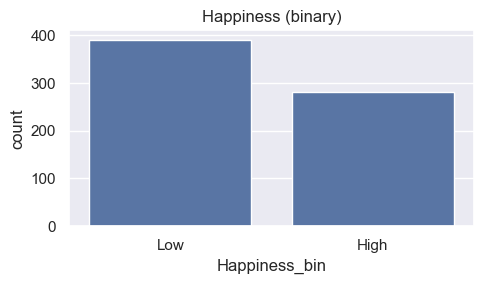

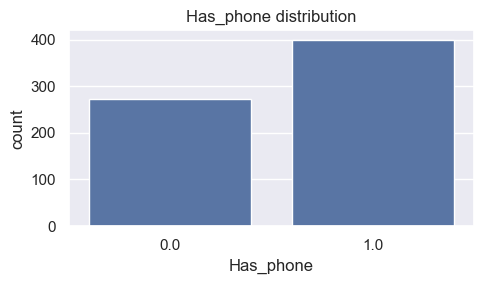

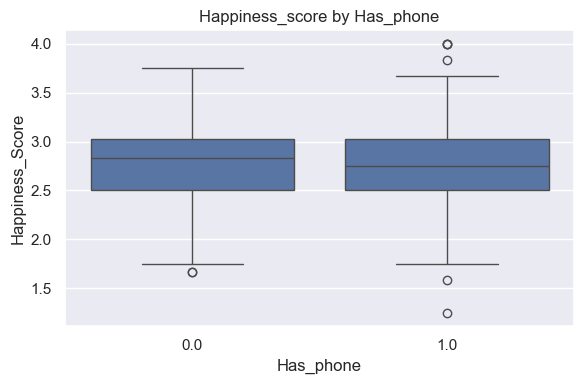

In [6]:

plt.figure(figsize=(5,3)); sns.countplot(x=y, order=["Low","High"]); plt.title("Happiness (binary)"); plt.tight_layout(); plt.show()
plt.figure(figsize=(5,3)); sns.countplot(x=df[HAS_PHONE_COL]); plt.title("Has_phone distribution"); plt.tight_layout(); plt.show()
plt.figure(figsize=(6,4)); sns.boxplot(x=df[HAS_PHONE_COL], y=y_raw); plt.title("Happiness_score by Has_phone"); plt.tight_layout(); plt.show()


In [7]:

X = df.drop(columns=[TARGET_COL]).copy()
if not pd.api.types.is_numeric_dtype(X[HAS_PHONE_COL]):
    X[HAS_PHONE_COL] = X[HAS_PHONE_COL].astype(str).str.strip().str.lower().map(
        {"1":1,"0":0,"true":1,"false":0,"yes":1,"no":0,"y":1,"n":0}
    ).astype("Int64")

cat_cols_generic = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
if PHONE_PURPOSE_COL + "_std" not in cat_cols_generic:
    cat_cols_generic.append(PHONE_PURPOSE_COL + "_std")
cat_cols_fixed = [PHONE_PURPOSE_COL + "_std"]
cat_cols_other = [c for c in cat_cols_generic if c not in cat_cols_fixed]
num_cols = [c for c in X.columns if c not in cat_cols_generic]

pre = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("purpose", OneHotEncoder(categories=[PURPOSE_CATEGORIES], handle_unknown="ignore", sparse_output=False), cat_cols_fixed),
    ("cat", Pipeline(steps=[("impute", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), cat_cols_other),
], remainder="drop")


Baseline Acc: 0.607 Macro-F1: 0.59


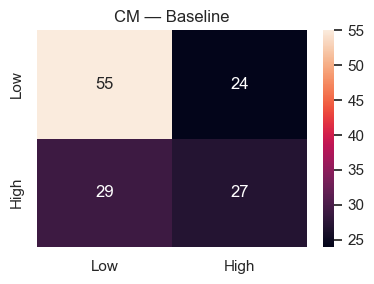

In [8]:

# Baseline: Has_phone only
X_base = X[[HAS_PHONE_COL]]
X_tr_b, X_te_b, y_tr_b, y_te_b = train_test_split(X_base, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
base = LogisticRegression(max_iter=1000, class_weight="balanced").fit(X_tr_b, y_tr_b)
pred_b = base.predict(X_te_b)
print("Baseline Acc:", round(accuracy_score(y_te_b, pred_b),3), "Macro-F1:", round(f1_score(y_te_b, pred_b, average="macro"),3))
cm_b = confusion_matrix(y_te_b, pred_b, labels=["Low","High"])
plt.figure(figsize=(4,3)); sns.heatmap(cm_b, annot=True, fmt="d", xticklabels=["Low","High"], yticklabels=["Low","High"]); plt.title("CM — Baseline"); plt.tight_layout(); plt.show()


/Users/sakagu/Documents/BF_survey/venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sakagu/Documents/BF_survey/venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-lear


=== LogReg ===
Best params: {'clf__C': 1.0, 'clf__solver': 'lbfgs', 'fs__k': 30}
Test Acc: 0.548 Macro-F1: 0.547
              precision    recall  f1-score   support

        High      0.465     0.589     0.520        56
         Low      0.641     0.519     0.573        79

    accuracy                          0.548       135
   macro avg      0.553     0.554     0.547       135
weighted avg      0.568     0.548     0.551       135



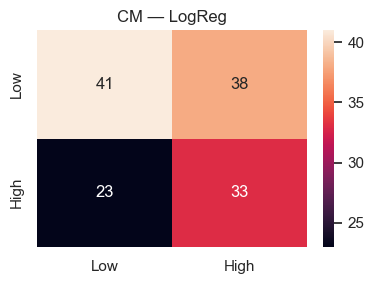


=== DecisionTree ===
Best params: {'clf__ccp_alpha': 0.0, 'clf__max_depth': None, 'clf__min_samples_leaf': 3, 'fs__k': 30}
Test Acc: 0.526 Macro-F1: 0.518
              precision    recall  f1-score   support

        High      0.435     0.482     0.458        56
         Low      0.603     0.557     0.579        79

    accuracy                          0.526       135
   macro avg      0.519     0.520     0.518       135
weighted avg      0.533     0.526     0.529       135



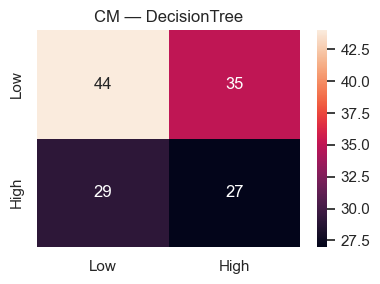


=== RandomForest ===
Best params: {'clf__max_depth': 8, 'clf__max_features': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 300, 'fs__k': 30}
Test Acc: 0.607 Macro-F1: 0.592
              precision    recall  f1-score   support

        High      0.528     0.500     0.514        56
         Low      0.659     0.684     0.671        79

    accuracy                          0.607       135
   macro avg      0.593     0.592     0.592       135
weighted avg      0.605     0.607     0.606       135



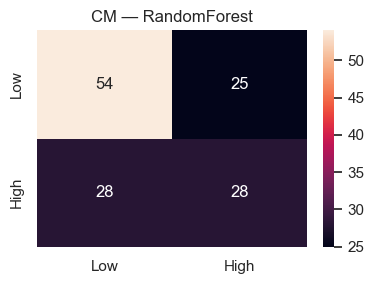


=== HistGB ===
Best params: {'clf__l2_regularization': 0.1, 'clf__learning_rate': 0.08, 'clf__max_depth': None, 'fs__k': 60}
Test Acc: 0.585 Macro-F1: 0.555
              precision    recall  f1-score   support

        High      0.500     0.393     0.440        56
         Low      0.626     0.722     0.671        79

    accuracy                          0.585       135
   macro avg      0.563     0.557     0.555       135
weighted avg      0.574     0.585     0.575       135



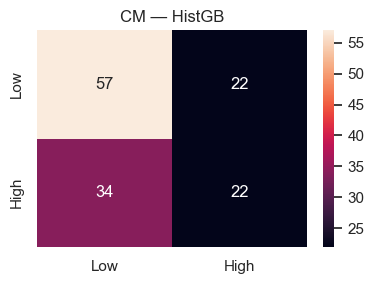


>>> Selected best model: RandomForest Macro-F1: 0.592


In [9]:

# Pipelines
pipe_logreg = Pipeline([("pre", pre), ("fs", SelectKBest(mutual_info_classif, k=TOP_K_FEATURES)), ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))])
pipe_tree   = Pipeline([("pre", pre), ("fs", SelectKBest(mutual_info_classif, k=TOP_K_FEATURES)), ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"))])
pipe_rf     = Pipeline([("pre", pre), ("fs", SelectKBest(mutual_info_classif, k=TOP_K_FEATURES)), ("clf", RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced_subsample"))])
pipe_hgb    = Pipeline([("pre", pre), ("fs", SelectKBest(mutual_info_classif, k=TOP_K_FEATURES)), ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))])

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

param_logreg = {"fs__k":[20,30,40,60], "clf__C":[0.3,1.0,3.0,10.0], "clf__solver":["lbfgs","liblinear"]}
param_tree   = {"fs__k":[20,30,40,60], "clf__max_depth":[3,5,8,None], "clf__min_samples_leaf":[1,3,10], "clf__ccp_alpha":[0.0,0.001,0.01]}
param_rf     = {"fs__k":[20,30,40,60], "clf__n_estimators":[300,500,800], "clf__max_depth":[None,8,16], "clf__min_samples_leaf":[1,3,8], "clf__max_features":["sqrt","log2",None]}
param_hgb    = {"fs__k":[20,30,40,60], "clf__max_depth":[None,3,5], "clf__learning_rate":[0.03,0.08,0.15], "clf__l2_regularization":[0.0,0.1,1.0]}

grids = {
    "LogReg": GridSearchCV(pipe_logreg, param_logreg, cv=cv, scoring="f1_macro", n_jobs=-1),
    "DecisionTree": GridSearchCV(pipe_tree, param_tree, cv=cv, scoring="f1_macro", n_jobs=-1),
    "RandomForest": GridSearchCV(pipe_rf, param_rf, cv=cv, scoring="f1_macro", n_jobs=-1),
    "HistGB": GridSearchCV(pipe_hgb, param_hgb, cv=cv, scoring="f1_macro", n_jobs=-1),
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

results = {}
for name, grid in grids.items():
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    pred = best.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1m = f1_score(y_test, pred, average="macro")
    results[name] = {"best_params": grid.best_params_, "test_acc": acc, "test_f1_macro": f1m, "estimator": best, "pred": pred}
    print(f"\n=== {name} ==="); print("Best params:", grid.best_params_); print("Test Acc:", round(acc,3), "Macro-F1:", round(f1m,3))
    print(classification_report(y_test, pred, digits=3))
    cm = confusion_matrix(y_test, pred, labels=["Low","High"])
    plt.figure(figsize=(4,3)); sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Low","High"], yticklabels=["Low","High"]); plt.title(f"CM — {name}"); plt.tight_layout(); plt.show()

best_name = max(results, key=lambda k: results[k]["test_f1_macro"])
best_model = results[best_name]["estimator"]
print("\n>>> Selected best model:", best_name, "Macro-F1:", round(results[best_name]["test_f1_macro"],3))


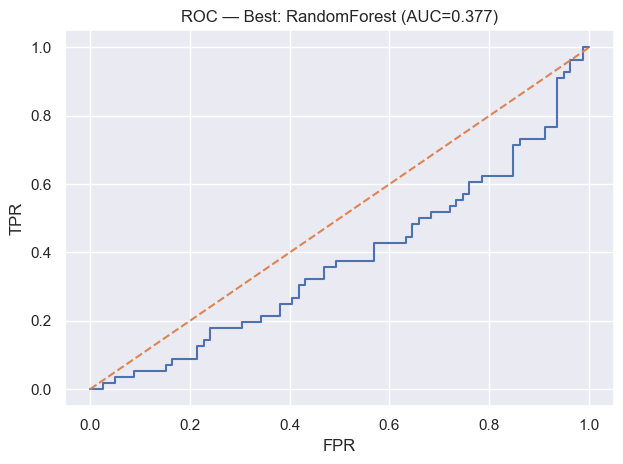

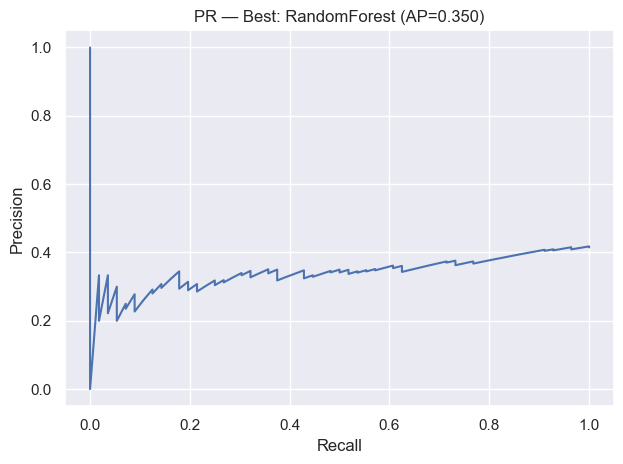

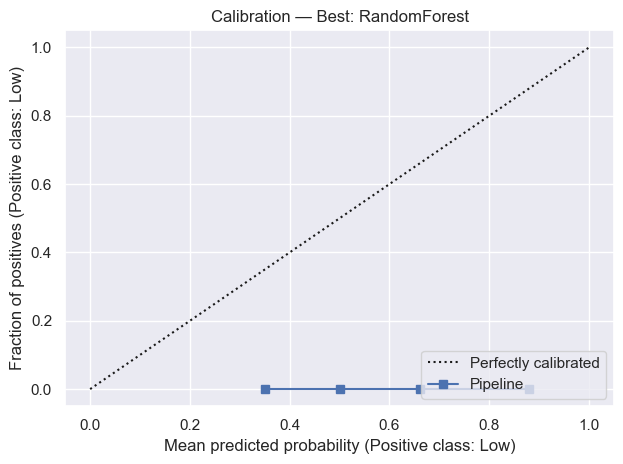

In [10]:

# Curves for best model
def plot_curves(model, X_test, y_test, title="Model"):
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        y_true = y_test.map({"Low":0,"High":1})
        fpr, tpr, _ = roc_curve(y_true, y_proba); roc_auc = auc(fpr, tpr)
        prec, rec, _ = precision_recall_curve(y_true, y_proba); ap = average_precision_score(y_true, y_proba)
        plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.title(f"ROC — {title} (AUC={roc_auc:.3f})"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.tight_layout(); plt.show()
        plt.figure(); plt.plot(rec, prec); plt.title(f"PR — {title} (AP={ap:.3f})"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.tight_layout(); plt.show()
        CalibrationDisplay.from_estimator(model, X_test, y_true); plt.title(f"Calibration — {title}"); plt.tight_layout(); plt.show()
    else:
        print(f"{title}: no predict_proba; skipping ROC/PR/Calibration.")

plot_curves(best_model, X_test, y_test, title=f"Best: {best_name}")


,feature,importance_mean,importance_std
0,num__Class,0.027037,0.026426
6,num__A6,0.020370,0.013833
4,num__A4,0.017407,0.012889
15,num__Has_phone,0.017407,0.013512
5,num__A5,0.014444,0.012053
1,num__Attention_Score,0.014444,0.026029
2,num__PhoneUse_Score,0.011111,0.023130
9,num__T7,0.010000,0.011541
7,num__A10,0.010000,0.022744
11,num__T11,0.007037,0.023480


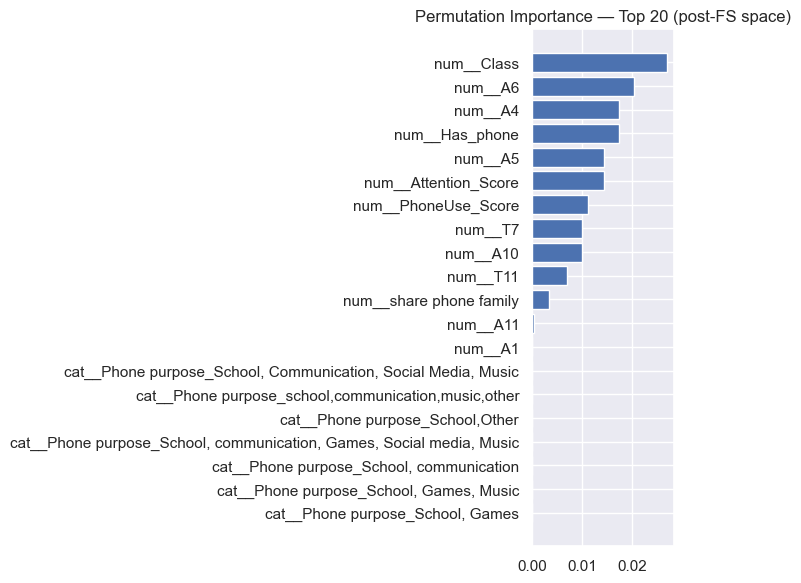

Saved: permutation_importance_top.csv


In [11]:

# Permutation Importance + PDP
preproc = best_model.named_steps["pre"]
fs      = best_model.named_steps["fs"]
clf     = best_model.named_steps["clf"]

# 1) transform X_test through preprocessor and feature selector
X_te_pre = preproc.transform(X_test)
X_te_sel = fs.transform(X_te_pre)

# 2) names after preprocessing, then mask down to selected features
fn_pre  = preproc.get_feature_names_out()
mask    = fs.get_support()
fn_sel  = np.array(fn_pre)[mask]

# 3) permutation importance on the *final estimator* with the selected matrix
perm = permutation_importance(
    clf, X_te_sel, y_test,
    n_repeats=20, random_state=RANDOM_STATE, n_jobs=-1
)

# 4) build table (now shapes match)
imp = pd.DataFrame({
    "feature": fn_sel,
    "importance_mean": perm.importances_mean,
    "importance_std":  perm.importances_std
}).sort_values("importance_mean", ascending=False)

display(imp.head(20))

plt.figure(figsize=(7,6))
top = imp.head(20).iloc[::-1]
plt.barh(top["feature"], top["importance_mean"])
plt.title("Permutation Importance — Top 20 (post-FS space)")
plt.tight_layout(); plt.show()

# (optional) save for appendix
imp.to_csv("permutation_importance_top.csv", index=False)
print("Saved: permutation_importance_top.csv")


In [12]:

# Summary + save predictions
summary = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy": [round(results[k]["test_acc"],3) for k in results],
    "Macro_F1": [round(results[k]["test_f1_macro"],3) for k in results]
}).sort_values("Macro_F1", ascending=False).reset_index(drop=True)
display(summary)

out = df.loc[y_test.index, [HAS_PHONE_COL, PHONE_PURPOSE_COL + "_std"]].copy()
out["true"] = y_test.values; out["pred"] = results[best_name]["pred"]
out_path = "happiness_test_predictions.csv"; out.to_csv(out_path, index=False)
print("Wrote:", out_path, "rows:", len(out))


,Model,Accuracy,Macro_F1
0,RandomForest,0.607,0.592
1,HistGB,0.585,0.555
2,LogReg,0.548,0.547
3,DecisionTree,0.526,0.518


Wrote: happiness_test_predictions.csv rows: 135
